In [61]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import scipy

In [3]:
# load the downloaded spacy model
NER = spacy.load("en_core_web_sm")
NER.max_length = 2202355

### Access the text files to establish character relations

In [4]:
import os

witcher_books = [book for book in os.scandir('data/witcher') if '.txt' in book.name]
malazan_books = [book for book in os.scandir('data/malazan') if '.txt' in book.name]

In [7]:
witcher_books, malazan_books

([<DirEntry '1 The Last Wish.txt'>,
  <DirEntry '2 The Sword of Destiny.txt'>,
  <DirEntry '3 Blood of Elves.txt'>,
  <DirEntry '4 Times of Contempt.txt'>,
  <DirEntry '5 Baptism of Fire.txt'>,
  <DirEntry '6 The Tower of the Swallow.txt'>,
  <DirEntry '7 The Lady of the Lake.txt'>,
  <DirEntry '8 something ends something begins.txt'>],
 [<DirEntry '1 Gardens Of The Moon.txt'>,
  <DirEntry '10 The Crippled God.txt'>,
  <DirEntry '2 Deadhouse Gates.txt'>,
  <DirEntry '3 Memories Of Ice.txt'>,
  <DirEntry '4 House Of Chains.txt'>,
  <DirEntry '5 Midnight Tides.txt'>,
  <DirEntry '6 The Bonehunters.txt'>,
  <DirEntry "7 Reaper's Gale.txt">,
  <DirEntry '8 Toll the Hounds.txt'>,
  <DirEntry '9 Dust Of Dreams.txt'>,
  <DirEntry 'Malazan Book Of The Fallen.txt'>])

Gonna perform analysis on one book for now: Reaper's gale, coz i haven't read ahead afraid of spoilers lol

In [5]:
book = malazan_books[7]
book

<DirEntry "7 Reaper's Gale.txt">

In [6]:
with open(book, 'r', encoding='utf-8', errors='replace') as file:
    book_text = file.read()

In [15]:
book_doc = NER(book_text)

In [16]:
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

### Load character names

In [31]:
character_df = pd.read_csv("malazan_chars.csv")

In [32]:
# get first name of characters
character_df['character_lastname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[-1])
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [33]:
character_df.drop('Unnamed: 0',axis=1,inplace=True)

In [34]:
character_df.head(10)

,book,character,character_lastname,character_firstname
0,Gardens of the Moon,Tattersail,Tattersail,Tattersail
1,Gardens of the Moon,Hairlock,Hairlock,Hairlock
2,Gardens of the Moon,Calot,Calot,Calot
3,Gardens of the Moon,Toc the Younger,the Younger,Toc
4,Gardens of the Moon,Sergeant Whiskeyjack,Whiskeyjack,Sergeant
5,Gardens of the Moon,Corporal Kalam,Kalam,Corporal
6,Gardens of the Moon,Quick Ben,Ben,Quick
7,Gardens of the Moon,Sorry,Sorry,Sorry
8,Gardens of the Moon,Hedge,Hedge,Hedge
9,Gardens of the Moon,Fiddler,Fiddler,Fiddler


In [35]:
def extract_primary_name(row):
    doc = NER(row['character'])
    primary_name = ""
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            primary_name = ent.text
            break
    return primary_name

character_df['IfEntityName'] = character_df.apply(extract_primary_name, axis=1)

In [30]:
character_df.head(10)

,book,character,character_firstname,PrimaryName
0,Gardens of the Moon,Tattersail,Tattersail,Tattersail
1,Gardens of the Moon,Hairlock,Hairlock,
2,Gardens of the Moon,Calot,Calot,
3,Gardens of the Moon,Toc the Younger,the Younger,
4,Gardens of the Moon,Sergeant Whiskeyjack,Whiskeyjack,Sergeant Whiskeyjack
5,Gardens of the Moon,Corporal Kalam,Kalam,
6,Gardens of the Moon,Quick Ben,Ben,Quick Ben
7,Gardens of the Moon,Sorry,Sorry,
8,Gardens of the Moon,Hedge,Hedge,
9,Gardens of the Moon,Fiddler,Fiddler,


### Get named entity list per sentence

In [36]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [38]:
sent_entity_df.tail(20)

,sentence,entities
33774,"(She, stared, after, him, ., \n)",[]
33775,"(She, needed, to, go, inside, now, ,, to, coll...",[]
33776,"(Yet, still, she, hesitated, ., \n)",[]
33777,"(And, the, old, man, suddenly, returned, .)",[]
33778,"(‘, I, found, the, Errant, ,, ’, he, said, .)",[Errant]
33779,"(‘, We, had, \n, much, to, …, discuss, .)",[]
33780,"(It, is, how, I, learned, of, you, ,, and, of,...",[]
33781,"(What, ?)",[]
33782,"(Is, he, addled, ,, then, ?)",[]
33783,"(One, of, the, Errant, ’s, new, zealots, ?)","[One, Errant]"


In [39]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [43]:
filter_entity(["Karsa", "Thu", "2"], character_df)

['Karsa']

In [44]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
34,"(Then, Kilmandaros, ,, the, Elder, Goddess, ,,...","[Kilmandaros, the Elder Goddess]",[Kilmandaros]
36,"(Gothos, had, no, difficulty, following, the, ...","[Gothos, two, Soletaken, Jaghut, Omtose Phellack]",[Gothos]
37,"(Sealing, the, deal, ,, as, you, asked, of, me...",[Mael],[Mael]
59,"(He, ascended, a, broken, ,, fractured, rise, ...",[Gothos],[Gothos]
61,"(Gothos, smiled, ., \n)",[Gothos],[Gothos]
63,"(As, Gothos, neared, ,, the, two, voices, ceas...","[Gothos, two, Jaghut]",[Gothos]
64,"(He, alighted, atop, broken, shards, of, rock,...","[Mael, ten, Kilmandaros]","[Mael, Kilmandaros]"
65,"(Scabandari, ,, the, Soletaken, dragon, ,, had...","[Scabandari, Soletaken]",[Scabandari]
69,"(The, two, Elders, were, now, eyeing, Gothos, ...","[two, Gothos]",[Gothos]
73,"(Mael, ,, Elder, God, of, the, Seas, ,, asked,...","[Mael, Gothos]","[Mael, Gothos]"


In [45]:
# Take only last name of characters
sent_entity_df_filtered['character_entities_lname'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[-1] for item in x])

C:\Users\Adithya\AppData\Local\Temp\ipykernel_8068\901255118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities_lname'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[-1] for item in x])


In [48]:
sent_entity_df_filtered.tail(20)

,sentence,entities,character_entities,character_entities_lname
33687,"(‘, I, applaud, your, embrace, of, incompetenc...",[Bugg],[Bugg],[Bugg]
33689,"(‘, Well, ,, ’, Brys, ventured, from, where, h...",[Brys],[Brys],[Brys]
33690,"(Bugg, grimaced, .)",[Bugg],[Bugg],[Bugg]
33698,"(Brys, said, ,, ‘, The, Adjunct, is, on, her, ...","[Brys, Shurq Elalle]","[Brys, Shurq Elalle]","[Brys, Elalle]"
33700,"(He, then, waited, for, a, reply, ,, any, repl...",[Bugg],[Bugg],[Bugg]
33704,"(Janath, ’s, expression, remained, aloof, .)",[Janath],[Janath],[Janath]
33707,"(‘, No, wonder, you, stand, out, so, in, here,...",[Bugg],[Bugg],[Bugg]
33708,"(‘, Besides, ,, ’, Janath, continued, ,, ‘, su...","[Janath, First Concubine]",[Janath],[Janath]
33711,"(‘, I, keep, telling, you, ,, ’, Bugg, said, .)",[Bugg],[Bugg],[Bugg]
33713,"(He, then, turned, to, Janath, .)",[Janath],[Janath],[Janath]


### Create relationships

In [49]:
window_size = 10
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [50]:
relationship_df = pd.DataFrame(relationships)

In [51]:
relationship_df.tail(20)

,source,target
19926,Tehol,Adjunct
19927,Janath,Tehol
19928,Tehol,Adjunct
19929,Adjunct,Brys
19930,Janath,Tehol
19931,Tehol,Adjunct
19932,Adjunct,Brys
19933,Janath,Tehol
19934,Tehol,Adjunct
19935,Adjunct,Brys


In [52]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Gothos,Kilmandaros
1,Gothos,Kilmandaros
2,Gothos,Mael
3,Gothos,Kilmandaros
4,Gothos,Mael
...,...,...
19941,Bugg,Seren Pedac
19942,Bugg,Seren Pedac
19943,Bugg,Seren Pedac
19944,Bugg,Seren Pedac


In [53]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [55]:
relationship_df.head(20)

,source,target,value
0,Gothos,Kilmandaros,34
1,Gothos,Mael,44
2,Kilmandaros,Mael,44
3,Kilmandaros,Scabandari,24
4,Gothos,Scabandari,9
5,Mael,Scabandari,7
6,Edgewalker,Kilmandaros,6
7,Osserc,Scabandari,9
8,Mael,Osserc,4
9,Anomandaris,Scabandari,8


### Graph analysis and visualisation

In [56]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

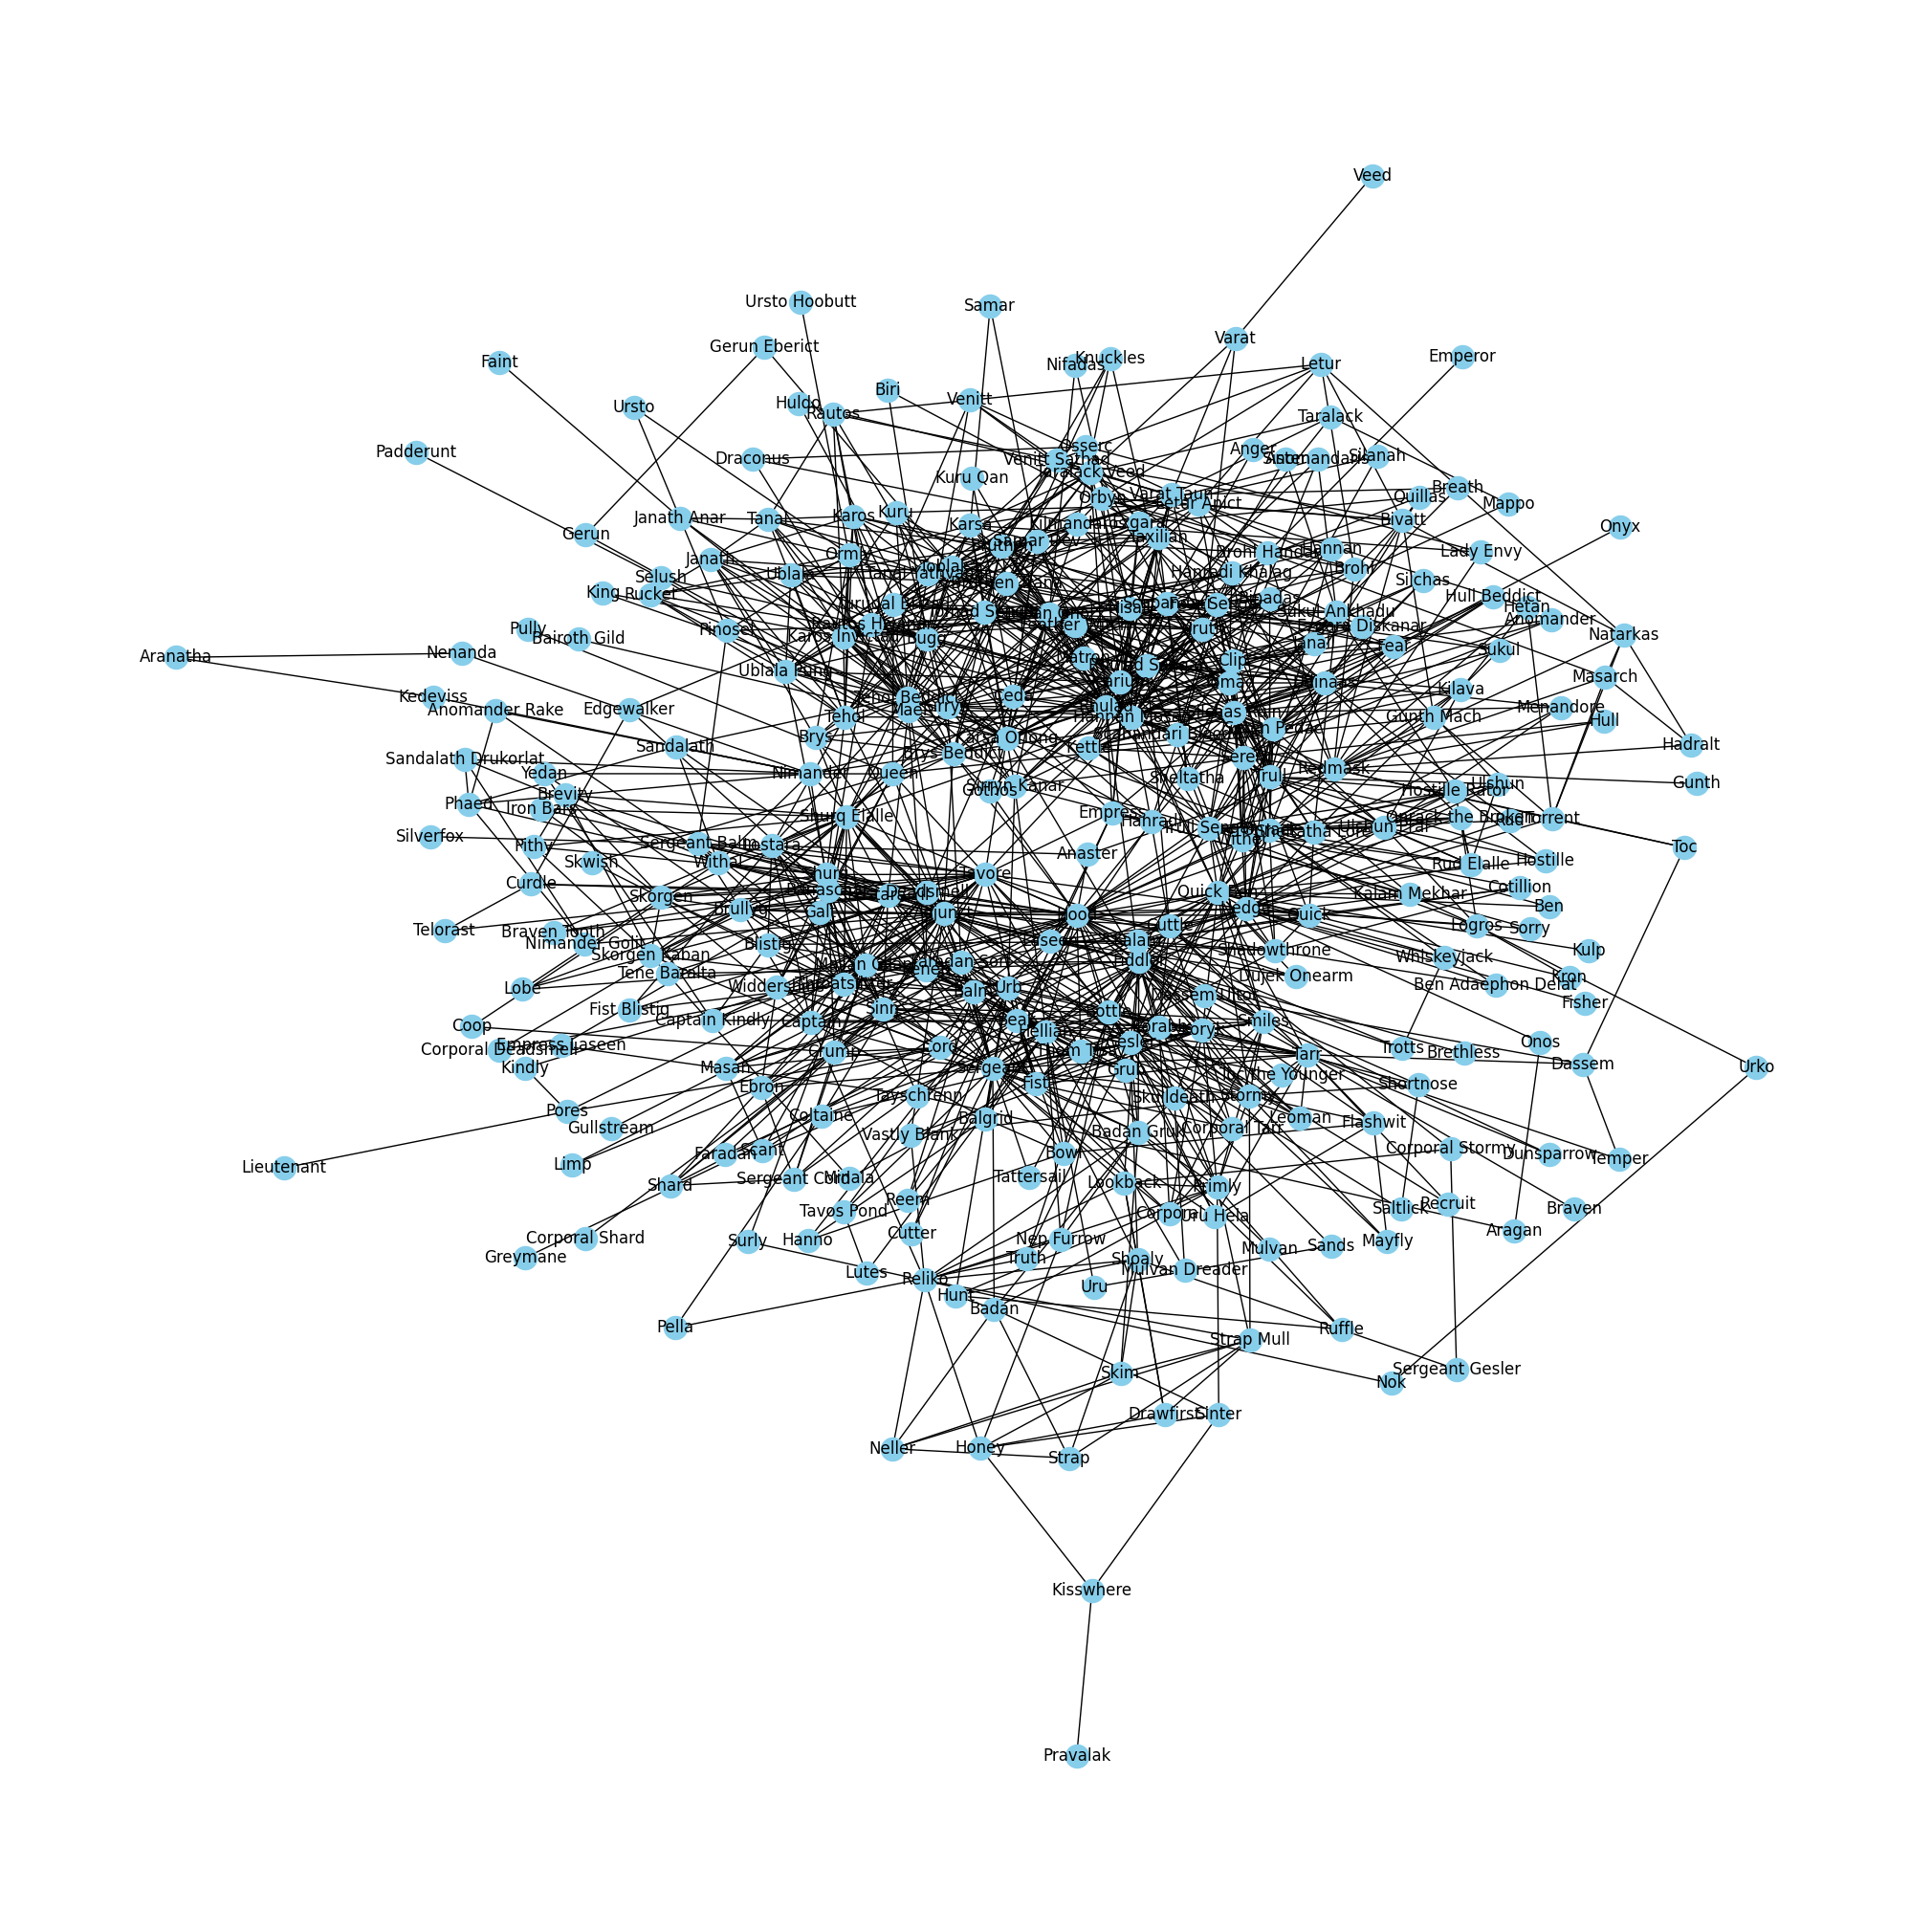

In [63]:
plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Use pyvis for graph visualization

In [ ]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("reapers_gale.html")

### Important characters in reaper's gale

In [65]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Gothos': 0.013651877133105802,
 'Kilmandaros': 0.040955631399317405,
 'Mael': 0.051194539249146756,
 'Scabandari': 0.07849829351535836,
 'Edgewalker': 0.010238907849829351,
 'Osserc': 0.017064846416382253,
 'Anomandaris': 0.013651877133105802,
 'Silchas Ruin': 0.10921501706484642,
 'Ceda': 0.06143344709897611,
 'Letur Anict': 0.04436860068259386,
 'Kuru': 0.023890784982935155,
 'Bivatt': 0.030716723549488054,
 'Karos Invictad': 0.08191126279863481,
 'Tanal Yathvanar': 0.05802047781569966,
 'Karos': 0.040955631399317405,
 'Bruthen': 0.05460750853242321,
 'Bruthen Trana': 0.06143344709897611,
 'Tanal': 0.03754266211604096,
 'Rautos': 0.023890784982935155,
 'Rautos Hivanar': 0.05460750853242321,
 'Venitt Sathad': 0.03754266211604096,
 'Venitt': 0.023890784982935155,
 'Brohl': 0.030716723549488054,
 'Brohl Handar': 0.04436860068259386,
 'Rhulad': 0.15699658703071673,
 'Udinaas': 0.09215017064846416,
 'Kettle': 0.04436860068259386,
 'Seren Pedac': 0.08191126279863481,
 'Seren': 0.07167235

<Axes: >

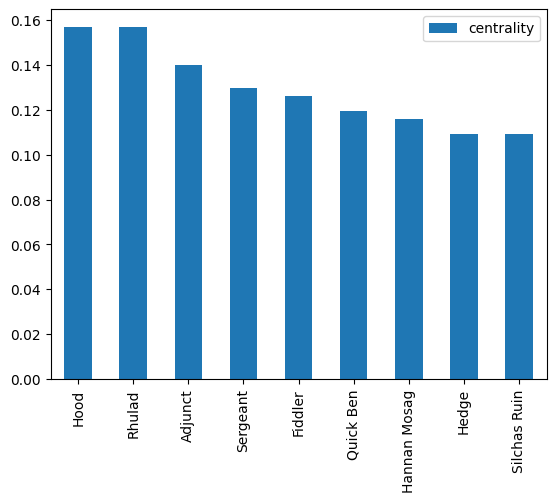

In [66]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

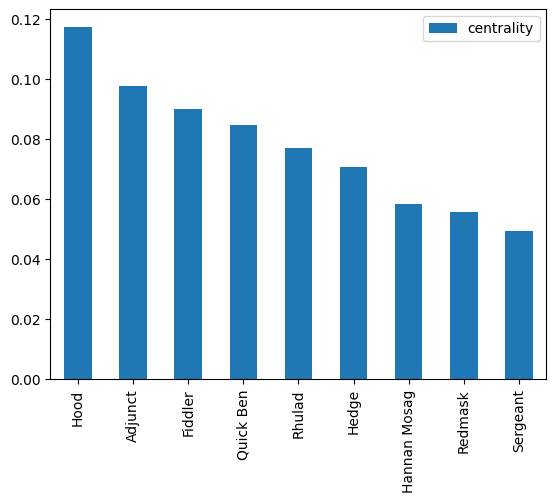

In [67]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

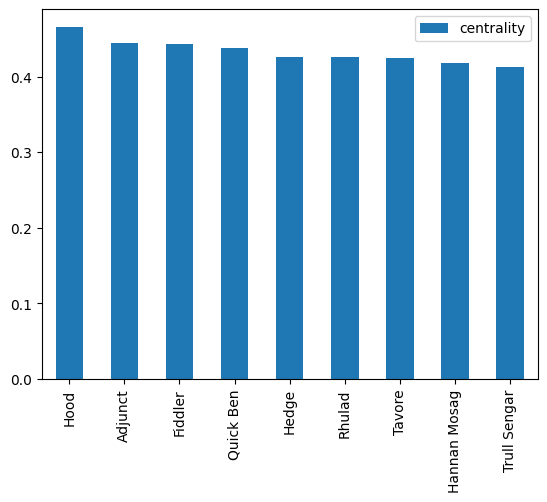

In [68]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [69]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [77]:
import community.community_louvain as community_louvain

In [78]:
communities = community_louvain.best_partition(G)

In [79]:
communities

{'Gothos': 0,
 'Kilmandaros': 0,
 'Mael': 0,
 'Scabandari': 0,
 'Edgewalker': 1,
 'Osserc': 0,
 'Anomandaris': 0,
 'Silchas Ruin': 2,
 'Ceda': 3,
 'Letur Anict': 4,
 'Kuru': 3,
 'Bivatt': 4,
 'Karos Invictad': 4,
 'Tanal Yathvanar': 4,
 'Karos': 4,
 'Bruthen': 0,
 'Bruthen Trana': 0,
 'Tanal': 4,
 'Rautos': 4,
 'Rautos Hivanar': 4,
 'Venitt Sathad': 4,
 'Venitt': 4,
 'Brohl': 4,
 'Brohl Handar': 4,
 'Rhulad': 3,
 'Udinaas': 2,
 'Kettle': 2,
 'Seren Pedac': 2,
 'Seren': 2,
 'Fear Sengar': 2,
 'Fear': 2,
 'Bugg': 4,
 'Ezgara': 3,
 'Tehol': 4,
 'Biri': 4,
 'Hull Beddict': 2,
 'Wither': 2,
 'Triban Gnol': 3,
 'Orbyn': 4,
 'Hannan Mosag': 3,
 'Redmask': 4,
 'Gunth Mach': 4,
 'Rhulad Sengar': 3,
 'Brys Beddict': 4,
 'Nisall': 3,
 'Nifadas': 3,
 'Turudal Brizad': 3,
 'Ezgara Diskanar': 3,
 'Janall': 3,
 'Quillas': 3,
 'Trull Sengar': 2,
 'Tomad': 3,
 'Trull': 2,
 'Binadas': 3,
 'Kuru Qan': 3,
 'King': 4,
 'Tehol Beddict': 4,
 'Skorgen': 1,
 'Skorgen Kaban': 1,
 'Shurq': 1,
 'Shurq Elalle': 1,

In [80]:
nx.set_node_attributes(G, communities, 'group')

In [ ]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("reapers_gale_communities.html")

### Evolution of characters' importance

In [ ]:
from lib.utils.functions import *

In [ ]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)